Our prediciton model for the RGB vector is


$$\widehat{\mathbf v}
\; = \;
\underbrace{\frac{Y}{\mathbf w^\top\mathbf w}\mathbf w}_{\mathbf{v}_{\parallel}}
\; + \;
\underbrace{\left[ (\hat{\alpha})\,\mathbf u_1
+ (\hat{\beta})\,\mathbf u_2 \right]}_{\mathbf{v}_{\perp}}$$

Because the search space is the entire 2D plane, the output is geometrically unconstrained. Under MSE loss, this often results in desaturation (regression to the mean), as the network averages conflicting color modes rather than selecting a precise hue.


Another problem is consider a sub-region of of the grayscale $Y$ where the graident at the center is zero. $\nabla Y_{ij} = 0$. Meaning the pixel and all its immediate neighbors have identical brightness

$$Y_{i,j} \approx Y_{i+1,j} \approx Y_{i,j+1} \approx \dots$$


In the baseline cnn model:


$$
\hat{\mathbf{v}}_{\perp}^{\text{CNN}} \in \mathbb{R}^2 \quad \left( (\alpha,\beta)\in \mathbb{R}^2 \right)
$$


where

Our baseline CNN  prediction is

$$\hat{\mathbf v}_{\perp}(i,j)
=
\begin{bmatrix}
\mathbf u_1 & \mathbf u_2
\end{bmatrix}
\,
f_\theta\!\big(Y_{\text{patch}}(i,j)\big)$$

$$
f_\theta\big( Y_{\text{patch}}(i,j) \big)   =
\begin{aligned}
\begin{bmatrix}
\hat{\alpha}(i,j)\\
\hat{\beta}(i,j)
\end{bmatrix}
\end{aligned}$$

with

$$\hat{\alpha}(i,j) = \langle W^{(\alpha)}, Y_{\text{patch}}(i,j)\rangle$$
$$\hat{\beta}(i,j) = \langle W^{(\beta)}, Y_{\text{patch}}(i,j)\rangle$$

and $f_{\theta} = L_L \circ L_{L-1} \circ \dots \circ L_1$ is a composition of layers

While the absolute chroma value $\hat{\mathbf{v}}_{\perp}$ may depend on the surrounding patch (to gather semantic context), the chroma variation $\nabla \hat{\mathbf{v}}_{\perp}$ must strictly follow the local luminance variation. Thus, we require:

$$\nabla Y_{ij} = \mathbf{0} \implies \nabla \hat{\mathbf{v}}_{ij} = \mathbf{0}$$

Consider the specific case where the center is flat, $\nabla Y(i,j) = \mathbf{0}$,  but the neighbor has an edge, $\nabla Y((i,j) + \mathbf{n}) \neq \mathbf{0}$.


The spatial gradient of the predicted $\alpha$-channel is:

$$\begin{aligned}
\nabla\hat{\alpha}(i,j)
\;&=\;
\langle
W^{(\alpha)},\;
\nabla Y_{\text{patch}}(i,j)
\rangle
\\[10pt]
\;&=\;
\cdots
\;+\;
W^{(\alpha)}_{\mathbf{0}}
\underbrace{\nabla Y(i,j)}_{\text{Center } (= \mathbf{0})}
\;+\;
W^{(\alpha)}_{\mathbf{n}}
\underbrace{\nabla Y((i,j)+\mathbf{n})}_{\text{Neighbor } (\neq \mathbf{0})}
\;+\;
\cdots
\end{aligned}
$$
$$
\begin{aligned}
\nabla\hat{\beta}(i,j)
\;&=\;
\langle
W^{(\beta)},\;
\nabla Y_{\text{patch}}(i,j)
\rangle
\\[10pt]
\;&=\;
\cdots
\;+\;
W^{(\beta)}_{\mathbf{0}}
\underbrace{\nabla Y(i,j)}_{\text{Center } (= \mathbf{0})}
\;+\;
W^{(\beta)}_{\mathbf{n}}
\underbrace{\nabla Y((i,j)+\mathbf{n})}_{\text{Neighbor } (\neq \mathbf{0})}
\;+\;
\cdots
\end{aligned}
$$

Ideally, the variation of the output ($\nabla \hat{\alpha}, \nabla \hat{\beta}$) should depend only on the variation of the center ($\nabla Y(i,j)$). However, the equation above shows that in a standard CNN, $\nabla \hat{\alpha}, \nabla \hat{\beta}$ is a weighted sum over the entire neighborhood's gradients
Thus

$$
\begin{array}{c} \nabla\hat{\mathbf v}_{ij}
\neq \mathbf{0},
\quad\text{even though}\quad
\nabla Y_{ij}=0 \end{array}
$$


The model has mathematically "leaked" the gradient information from the neighbor $((i,j)+\mathbf{n})$ into the prediction for the center $(i,j)$, causing edge misalignment.


# Hybrid

In the hybrid model we define

$$\alpha = \mathbf a^\top \mathbf z, \quad \beta = \mathbf b^\top \mathbf z$$

Where the features $\mathbf z_{ij}$ are fixed with our handpicked kernals $K^{(k)}$

$$
\begin{array}{c} \mathbf z_{ij} =
\begin{bmatrix}
\langle K^{(1)},\, Y_{\text{patch}}(i,j) \rangle_F \\
\langle K^{(2)},\, Y_{\text{patch}}(i,j) \rangle_F \\
\vdots \\
\langle K^{(m)},\, Y_{\text{patch}}(i,j) \rangle_F
\end{bmatrix} \end{array}
$$


So our model is
$$
\widehat{\mathbf v}
\; = \;
\underbrace{\frac{y}{\mathbf w^\top\mathbf w}\mathbf w}_{\mathbf{v}_{\parallel}}
\; + \;
\underbrace{\Big[ (\mathbf a^\top \mathbf z)\,\mathbf u_1
+ (\mathbf b^\top \mathbf z)\,\mathbf u_2 \Big]}_{\mathbf{v}_{\perp}}
$$


In this model, we we use CNN to predicti $\alpha$ and $\beta$ instead. While $\mathbf v_\perp$ is still in the color plane spanned by $\mathbf u_1,\mathbf u_2$, but how it move in that plane isn ow constrained by $\mathbf{z}$ as we force $\alpha ,\beta$ to be linear in fixed features $\mathbf{z}_{ij}$. As opposed to the baseline CNN  model, which it must learn where the edges/textures are and what chroma to assign.

This also fix the MIsalignment Problem in the baseline CNN.

if $\nabla Y_{ij} = 0 $ then

$$
\nabla \hat{\alpha} = \underbrace{(\nabla \mathbf{a}) \cdot \mathbf{z}}_{\text{Term 1}} + \underbrace{\mathbf{a} \cdot (\nabla \mathbf{z})}_{\text{Term 2}}
$$

**Term 2** vanishes as $ \nabla \mathbf{z} = \mathbf{0}$ as $\nabla z = z_{i+1} - z_i$. So if $Y$ is flat, i.e $Y = [\dots, \mathbf{10, 10, 10}, 10, \dots]^{\top}$, $ \nabla z = 0$ and consequentially $\nabla \mathbf{z} = \mathbf{0}$

For **Term 1** Because CNNs involve pooling and strided convolutions (downsampling), the output $\mathbf{a}$ is naturally  smooth  (low-frequency). $\nabla \mathbf{a} \approx 0$ is very small. Thus $ \nabla (\mathbf a^\top \mathbf z) \approx 0 ,  \nabla (\mathbf b^\top \mathbf z) \approx 0$.

Thus $\nabla Y_{ij} = 0 \implies \nabla \mathbf{v}_{\perp} \approx 0$



$$
\begin{aligned}
\mathbf{v}
\; &= \;

&= \;
\underbrace{\frac{y}{\mathbf{w}^\top \mathbf{w}}\,\mathbf{w}}_{\text{brightness part of $\mathbf{v}$}}
+
\underbrace{\Big(\mathbf{v} - \frac{y}{\mathbf{w}^\top \mathbf{w}}\,\mathbf{w}\Big)}_{\text{the missing part of $\mathbf{v}$}}
&& \text{ as y = $\mathbf{w}^{\top} \mathbf{v}$}\\[5pt]
&=
\underbrace{y}_{\text{luminosity} \\ \text{scalar} \\ y \in \{0,..,255\} }
\underbrace{\left({\frac{1}{\mathbf{w}^\top \mathbf{w}}}\,\mathbf{w} \right)}_{\text{3D vector}}
+
\underbrace{\left(\mathbf{v} - y \frac{1}{\mathbf{w}^\top \mathbf{w}}\,\mathbf{w} \right)}_{\text{the missing part of $\mathbf{v}$ } \\ \text{without  luminosity (chroma)} } \\[5pt]
&= \mathbf{v}_{\parallel} + \mathbf{v}_{\perp}
\end{aligned}
$$

In [ ]:
# =========================================================
# SHARED CODE
# =========================================================

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

image_dim = 32

# ---------- basis ----------
def compute_orthonormal_basis(w, device='cpu'):
    w_norm = w / torch.norm(w)
    tmp = torch.tensor([1.,0.,0.],device=device) if abs(w_norm[0]) < 0.9 else torch.tensor([0.,1.,0.],device=device)
    u1 = tmp - w_norm * torch.dot(tmp,w_norm)
    u1 = u1 / (torch.norm(u1) + 1e-8)
    u2 = torch.linalg.cross(w_norm,u1)
    u2 = u2 / (torch.norm(u2) + 1e-8)
    return u1, u2

# ---------- reconstruction ----------
def reconstruct_color(Y_target, alpha, beta, w, u1, u2):
    w2 = torch.dot(w,w)
    v_parallel = (Y_target/w2).unsqueeze(1)*w
    v_perp = alpha.unsqueeze(1)*u1 + beta.unsqueeze(1)*u2
    return v_parallel + v_perp

# ---------- dataset ----------
def load_cifar10(batch_size=64):
    global image_dim
    image_dim = 32
    tf = transforms.Compose([transforms.ToTensor()])
    train = datasets.CIFAR10(root="./data",train=True,download=True,transform=tf)
    test  = datasets.CIFAR10(root="./data",train=False,download=True,transform=tf)
    return (torch.utils.data.DataLoader(train,batch_size=batch_size,shuffle=True,num_workers=2),
            torch.utils.data.DataLoader(test ,batch_size=batch_size,shuffle=False,num_workers=2))

# ---------- load model ----------
def load_model(model_class, path, device):
    model = model_class().to(device)
    model.load_state_dict(torch.load(path, map_location=device))
    model.eval()
    print(f"Loaded {path}")
    return model

# ---------- evaluate ----------
@torch.no_grad()
def evaluate(model, loader, w, u1, u2, device):
    total_loss = 0
    for imgs,_ in loader:
        imgs = imgs.to(device)
        Y = (imgs*w.view(1,3,1,1)).sum(dim=1,keepdim=True)

        a,b = model(Y)
        alpha = a.permute(0,2,3,1).reshape(-1)
        beta  = b.permute(0,2,3,1).reshape(-1)
        Yf = Y.permute(0,2,3,1).reshape(-1)

        Vt = imgs.permute(0,2,3,1).reshape(-1,3)
        Vp = reconstruct_color(Yf,alpha,beta,w,u1,u2)

        total_loss += ((Vp-Vt)**2).mean().item()
    return total_loss / len(loader)

# ---------- visualize ----------
@torch.no_grad()
def show_predictions(model, loader, w, u1, u2, device, num_images=5):
    imgs,_ = next(iter(loader))
    imgs = imgs[:num_images].to(device)
    Y = (imgs*w.view(1,3,1,1)).sum(dim=1,keepdim=True)
    a,b = model(Y)

    fig,ax = plt.subplots(num_images,3,figsize=(10,4*num_images))
    for i in range(num_images):
        gray = Y[i,0].cpu().numpy()

        alpha = a[i].permute(1,2,0).reshape(-1)
        beta  = b[i].permute(1,2,0).reshape(-1)
        Yf = Y[i].permute(1,2,0).reshape(-1)

        Vp = reconstruct_color(Yf,alpha,beta,w,u1,u2)
        Vp = Vp.reshape(image_dim,image_dim,3).clamp(0,1).cpu().numpy()

        gt = imgs[i].permute(1,2,0).cpu().numpy()

        ax[i,0].imshow(gray,cmap="gray"); ax[i,0].axis("off")
        ax[i,1].imshow(Vp);             ax[i,1].axis("off")
        ax[i,2].imshow(gt);             ax[i,2].axis("off")

    plt.show()


In [ ]:
# =========================================================
#  BASELINE MODEL
# =========================================================

class ColorizationCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1,32,4,stride=2,padding=1); self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32,64,4,stride=2,padding=1); self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64,128,4,stride=2,padding=1); self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128,128,3,padding=1); self.bn4 = nn.BatchNorm2d(128)
        self.conv5 = nn.Conv2d(128,128,3,padding=1); self.bn5 = nn.BatchNorm2d(128)
        self.tconv1 = nn.ConvTranspose2d(128,64,4,stride=2,padding=1); self.tbn1 = nn.BatchNorm2d(64)
        self.tconv2 = nn.ConvTranspose2d(64,32,4,stride=2,padding=1); self.tbn2 = nn.BatchNorm2d(32)
        self.tconv3 = nn.ConvTranspose2d(32,2,4,stride=2,padding=1)

    def forward(self,L):
        x = F.relu(self.bn1(self.conv1(L)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = F.relu(self.bn5(self.conv5(x)))
        x = F.relu(self.tbn1(self.tconv1(x)))
        x = F.relu(self.tbn2(self.tconv2(x)))
        x = self.tconv3(x)
        return x[:,0:1], x[:,1:2]


In [ ]:
# =========================================================
# HYBRID MODEL: SLR + CNN
# =========================================================

class FixedFeatureExtractor(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(1,4,3,padding=1,bias=False)
        self._init()
        for p in self.parameters(): p.requires_grad=False

    def _init(self):
        sx  = torch.tensor([[-1,0,1],[-2,0,2],[-1,0,1]],dtype=torch.float32)
        sy  = torch.tensor([[-1,-2,-1],[0,0,0],[1,2,1]],dtype=torch.float32)
        lap = torch.tensor([[0,1,0],[1,-4,1],[0,1,0]],dtype=torch.float32)
        ide = torch.tensor([[0,0,0],[0,1,0],[0,0,0]],dtype=torch.float32)
        k = torch.stack([sx,sy,lap,ide]).unsqueeze(1)
        self.conv.weight.data = k

    def forward(self,Y):
        return self.conv(Y)


class HybridColorizationCNN(nn.Module):
    def __init__(self,m=4):
        super().__init__()
        self.m = m
        self.fixed = FixedFeatureExtractor()

        self.conv1 = nn.Conv2d(1,32,4,stride=2,padding=1); self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32,64,4,stride=2,padding=1); self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64,128,4,stride=2,padding=1); self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128,128,3,padding=1); self.bn4 = nn.BatchNorm2d(128)
        self.conv5 = nn.Conv2d(128,128,3,padding=1); self.bn5 = nn.BatchNorm2d(128)
        self.tconv1 = nn.ConvTranspose2d(128,64,4,stride=2,padding=1); self.tbn1 = nn.BatchNorm2d(64)
        self.tconv2 = nn.ConvTranspose2d(64,32,4,stride=2,padding=1); self.tbn2 = nn.BatchNorm2d(32)
        self.tconv3 = nn.ConvTranspose2d(32,2*m,4,stride=2,padding=1)

    def forward(self,L):
        with torch.no_grad():
            z = self.fixed(L)

        x = F.relu(self.bn1(self.conv1(L)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = F.relu(self.bn5(self.conv5(x)))
        x = F.relu(self.tbn1(self.tconv1(x)))
        x = F.relu(self.tbn2(self.tconv2(x)))
        x = self.tconv3(x)

        A,B = torch.chunk(x,2,dim=1)
        alpha = (A*z).sum(dim=1,keepdim=True)
        beta  = (B*z).sum(dim=1,keepdim=True)
        return alpha,beta


In [ ]:
# =========================================================
# TRAIN + EVALUATE BASELINE MODEL
# =========================================================

device = "cuda" if torch.cuda.is_available() else "cpu"
print("DEVICE:", device)

# luminance basis
w = torch.tensor([0.299, 0.587, 0.114], device=device)
u1, u2 = compute_orthonormal_basis(w, device=device)

# dataset
train_loader, test_loader = load_cifar10(batch_size=64)

def train_one_epoch(model, loader, w, u1, u2, optimizer, device):
    model.train()
    total_loss = 0.0
    for imgs, _ in loader:
        imgs = imgs.to(device)
        Y = (imgs * w.view(1, 3, 1, 1)).sum(dim=1, keepdim=True)

        optimizer.zero_grad()
        a_pred, b_pred = model(Y)

        alpha = a_pred.permute(0, 2, 3, 1).reshape(-1)
        beta  = b_pred.permute(0, 2, 3, 1).reshape(-1)
        Y_flat = Y.permute(0, 2, 3, 1).reshape(-1)

        V_target = imgs.permute(0, 2, 3, 1).reshape(-1, 3)
        V_pred   = reconstruct_color(Y_flat, alpha, beta, w, u1, u2)

        loss = ((V_pred - V_target) ** 2).mean()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(loader)

baseline_model = ColorizationCNN().to(device)
optimizer_base = torch.optim.Adam(baseline_model.parameters(), lr=1e-3)

EPOCHS = 50
for epoch in range(1, EPOCHS + 1):
    train_loss = train_one_epoch(baseline_model, train_loader, w, u1, u2, optimizer_base, device)
    val_loss   = evaluate(baseline_model, test_loader, w, u1, u2, device)
    print(f"[BASELINE] Epoch {epoch:02d} | train {train_loss:.6f} | val {val_loss:.6f}")

print("\nBaseline predictions:")
show_predictions(baseline_model, test_loader, w, u1, u2, device, num_images=5)


DEVICE: cuda


100%|██████████| 170M/170M [00:03<00:00, 46.3MB/s]


[BASELINE] Epoch 01 | train 0.013059 | val 0.007823
[BASELINE] Epoch 02 | train 0.007534 | val 0.007392


DEVICE: cuda
[HYBRID]   Epoch 01 | train 0.006840 | val 0.005425
[HYBRID]   Epoch 02 | train 0.005352 | val 0.005222
[HYBRID]   Epoch 03 | train 0.005225 | val 0.005231
[HYBRID]   Epoch 04 | train 0.005126 | val 0.005111
[HYBRID]   Epoch 05 | train 0.005029 | val 0.005170
[HYBRID]   Epoch 06 | train 0.004914 | val 0.005028
[HYBRID]   Epoch 07 | train 0.004826 | val 0.005032
[HYBRID]   Epoch 08 | train 0.004656 | val 0.005123
[HYBRID]   Epoch 09 | train 0.004482 | val 0.005137
[HYBRID]   Epoch 10 | train 0.004245 | val 0.005257
[HYBRID]   Epoch 11 | train 0.004045 | val 0.005241
[HYBRID]   Epoch 12 | train 0.003804 | val 0.005406
[HYBRID]   Epoch 13 | train 0.003593 | val 0.005361
[HYBRID]   Epoch 14 | train 0.003405 | val 0.005640
[HYBRID]   Epoch 15 | train 0.003254 | val 0.005661
[HYBRID]   Epoch 16 | train 0.003112 | val 0.005467
[HYBRID]   Epoch 17 | train 0.002995 | val 0.005571
[HYBRID]   Epoch 18 | train 0.002898 | val 0.005768
[HYBRID]   Epoch 19 | train 0.002800 | val 0.005809

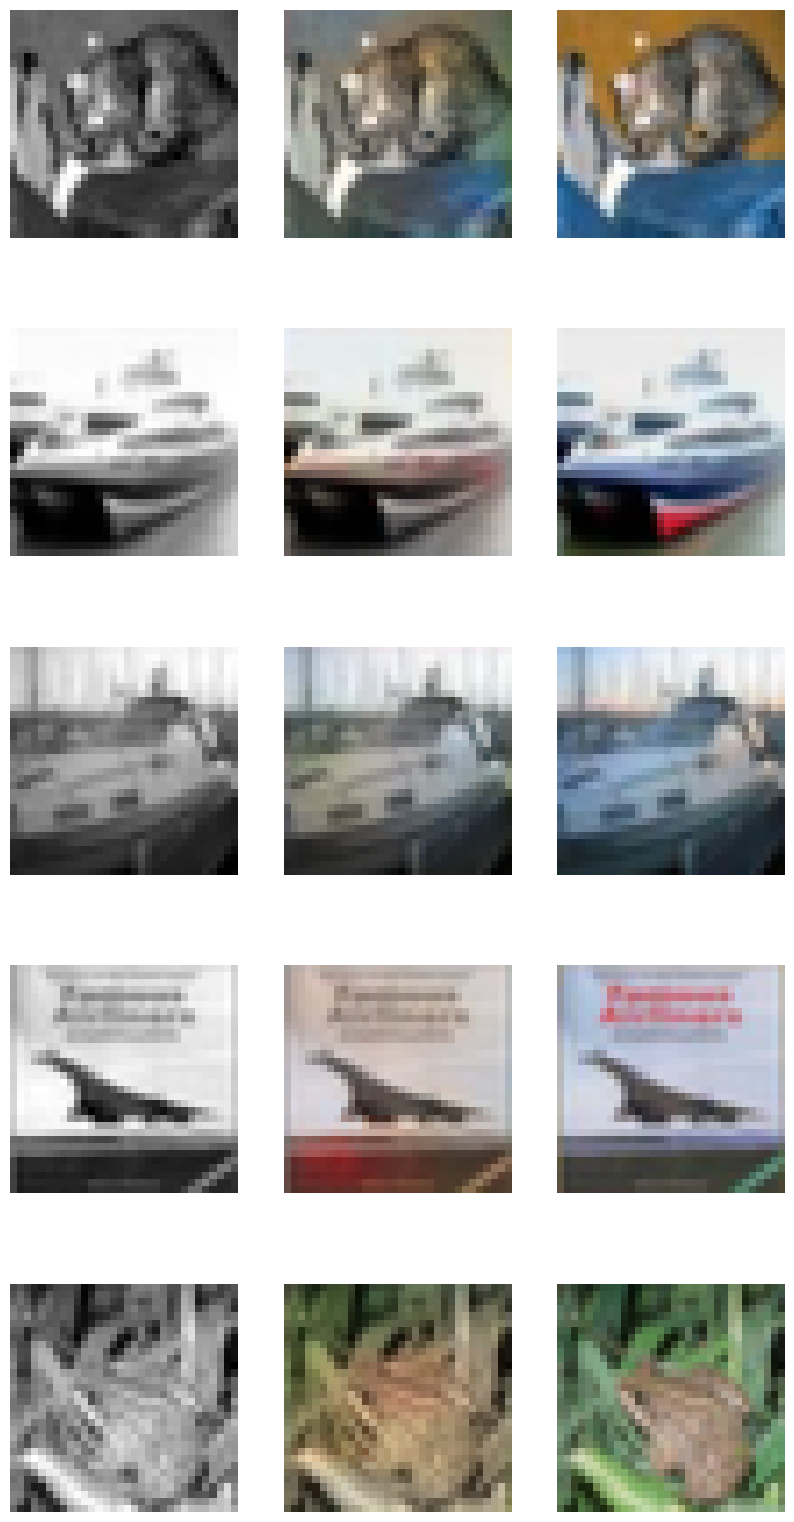

In [ ]:
# =========================================================
# TRAIN + EVALUATE HYBRID MODEL
# =========================================================


print("DEVICE:", device)

hybrid_model = HybridColorizationCNN().to(device)
optimizer_hybrid = torch.optim.Adam(hybrid_model.parameters(), lr=1e-3)

EPOCHS = 50
for epoch in range(1, EPOCHS + 1):
    train_loss = train_one_epoch(hybrid_model, train_loader, w, u1, u2, optimizer_hybrid, device)
    val_loss   = evaluate(hybrid_model, test_loader, w, u1, u2, device)
    print(f"[HYBRID]   Epoch {epoch:02d} | train {train_loss:.6f} | val {val_loss:.6f}")

print("\nHybrid predictions:")
show_predictions(hybrid_model, test_loader, w, u1, u2, device, num_images=5)


In [18]:
# =========================================================
# LOAD ALL MODELS AND COMPUTE MSE TABLE
# =========================================================

from google.colab import drive
import os
import torch

# -------------------- MOUNT DRIVE --------------------
drive.mount('/content/drive')

# -------------------- PATHS TO MODELS --------------------
model_folder = "/content/drive/MyDrive/models"
model_files = {
    "CIFAR_base": os.path.join(model_folder, "CIFAR_base.pth"),
    "CIFAR_hybrid": os.path.join(model_folder, "CIFAR_hybrid.pth"),
    "Flowers_base": os.path.join(model_folder, "Flowers_base.pth"),
    "Flowers_hybrid": os.path.join(model_folder, "Flowers_hybrid.pth"),
    "STL_base": os.path.join(model_folder, "STL_base.pth"),
    "STL_hybrid": os.path.join(model_folder, "STL_hybrid.pth")
}

# -------------------- HELPER FUNCTION --------------------
def safe_load_model(model_class, path, device):
    if os.path.exists(path):
        model = model_class().to(device)
        state_dict = torch.load(path, map_location=device)

        # rename keys if necessary
        new_state_dict = {}
        for k, v in state_dict.items():
            new_key = k.replace("fixed_features", "fixed")
            new_state_dict[new_key] = v

        model.load_state_dict(new_state_dict)
        model.eval()
        print(f"Loaded model from {path}")
        return model
    else:
        print(f"Model file not found: {path}")
        return None

# -------------------- COMPUTE MSE --------------------
device = "cuda" if torch.cuda.is_available() else "cpu"
model_mse = {}

for name, path in model_files.items():
    model_class = HybridColorizationCNN if "hybrid" in name else ColorizationCNN
    model = safe_load_model(model_class, path, device)
    if model is not None:
        val_mse = evaluate(model, test_loader, w, u1, u2, device)
        model_mse[name] = val_mse
        print(f"[{name}] Validation MSE = {val_mse:.6f}")
    else:
        model_mse[name] = None

# -------------------- COMPUTE RATIOS & IMPROVEMENTS --------------------
datasets = ["CIFAR", "flowers", "STL"]
mse_table = {}

for dataset in datasets:
    base_mse = model_mse.get(f"{dataset}_base")
    hybrid_mse = model_mse.get(f"{dataset}_hybrid")

    if base_mse is not None and hybrid_mse is not None:
        ratio = hybrid_mse / base_mse
        improvement = (base_mse - hybrid_mse) / base_mse * 100
        mse_table[dataset] = {"ratio": ratio, "improvement": improvement}
        print(f"{dataset}: Hybrid/Base ratio = {ratio:.3f}, Improvement = {improvement:.2f}%")
    else:
        print(f"{dataset}: Missing model(s), skipping.")

# -------------------- SUMMARY --------------------
print("\n===== FULL MSE DICTIONARY =====")
for name, mse in model_mse.items():
    print(f"{name}: {mse}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loaded model from /content/drive/MyDrive/models/CIFAR_base.pth
[CIFAR_base] Validation MSE = 0.007763
Loaded model from /content/drive/MyDrive/models/CIFAR_hybrid.pth
[CIFAR_hybrid] Validation MSE = 0.005827
Loaded model from /content/drive/MyDrive/models/Flowers_base.pth
[Flowers_base] Validation MSE = 0.012417
Loaded model from /content/drive/MyDrive/models/Flowers_hybrid.pth
[Flowers_hybrid] Validation MSE = 0.009101
Loaded model from /content/drive/MyDrive/models/STL_base.pth
[STL_base] Validation MSE = 0.005774
Loaded model from /content/drive/MyDrive/models/STL_hybrid.pth
[STL_hybrid] Validation MSE = 0.005577
CIFAR: Hybrid/Base ratio = 0.751, Improvement = 24.94%
flowers: Missing model(s), skipping.
STL: Hybrid/Base ratio = 0.966, Improvement = 3.42%

===== FULL MSE DICTIONARY =====
CIFAR_base: 0.0077628283108922705
CIFAR_hybrid: 0.005826838864725392
F

In [ ]:
# =========================================================
#Compare MSE
# =========================================================

ratio = hybrid_val / baseline_val
print(f"Hybrid MSE / Baseline MSE = {ratio:.3f}")

if ratio < 1:
    print("Hybrid is BETTER (lower error).")
else:
    print("Hybrid is WORSE (higher error).")


improvement = (baseline_val - hybrid_val) / baseline_val * 100
print(f"Hybrid improves test MSE by {improvement:.2f}%")



Hybrid MSE / Baseline MSE = 0.931
Hybrid is BETTER (lower error).
Hybrid improves test MSE by 6.93%


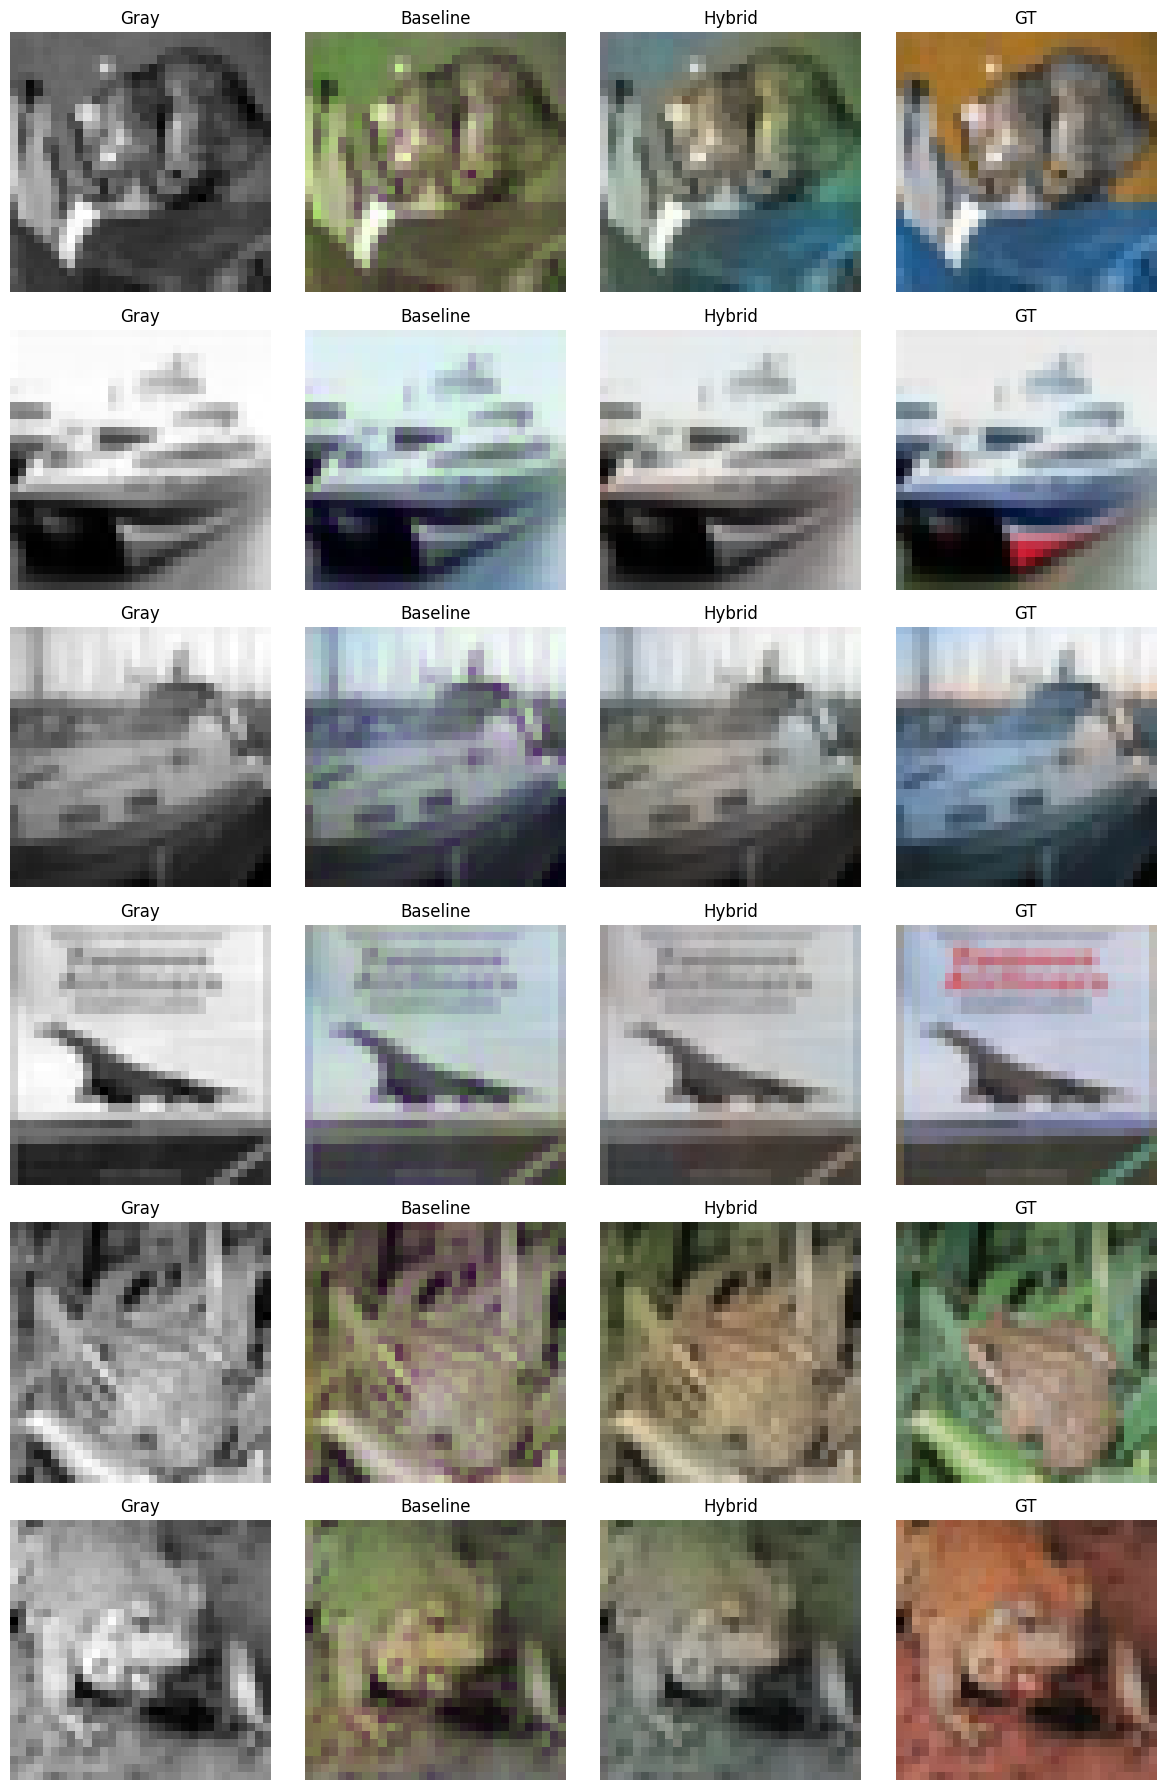

In [ ]:
# =========================================================
#  Compare OUTPUTS
# =========================================================

@torch.no_grad()
def compare_models_side_by_side(baseline_model, hybrid_model,
                                loader, w, u1, u2, device,
                                num_images=5):
    baseline_model.eval()
    hybrid_model.eval()

    imgs, _ = next(iter(loader))
    imgs = imgs[:num_images].to(device)

    Y = (imgs * w.view(1, 3, 1, 1)).sum(dim=1, keepdim=True)

    a_base, b_base = baseline_model(Y)
    a_hyb,  b_hyb  = hybrid_model(Y)

    fig, axes = plt.subplots(num_images, 4, figsize=(12, 3 * num_images))

    for i in range(num_images):
        row = axes[i] if num_images > 1 else axes

        gray = Y[i, 0].cpu().numpy()
        gt   = imgs[i].permute(1, 2, 0).cpu().numpy()

        # Baseline
        alpha_b = a_base[i].permute(1, 2, 0).reshape(-1)
        beta_b  = b_base[i].permute(1, 2, 0).reshape(-1)
        Y_flat  = Y[i].permute(1, 2, 0).reshape(-1)
        V_pred_b = reconstruct_color(Y_flat, alpha_b, beta_b, w, u1, u2)
        V_pred_b = V_pred_b.reshape(image_dim, image_dim, 3).clamp(0, 1).cpu().numpy()

        # Hybrid
        alpha_h = a_hyb[i].permute(1, 2, 0).reshape(-1)
        beta_h  = b_hyb[i].permute(1, 2, 0).reshape(-1)
        V_pred_h = reconstruct_color(Y_flat, alpha_h, beta_h, w, u1, u2)
        V_pred_h = V_pred_h.reshape(image_dim, image_dim, 3).clamp(0, 1).cpu().numpy()

        # Plot
        row[0].imshow(gray, cmap="gray"); row[0].set_title("Gray");      row[0].axis("off")
        row[1].imshow(V_pred_b);          row[1].set_title("Baseline");  row[1].axis("off")
        row[2].imshow(V_pred_h);          row[2].set_title("Hybrid");    row[2].axis("off")
        row[3].imshow(gt);                row[3].set_title("GT");        row[3].axis("off")

    plt.tight_layout()
    plt.show()

compare_models_side_by_side(
    baseline_model,
    hybrid_model,
    test_loader,
    w, u1, u2,
    device,
    num_images=6
)
